In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import darts
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from statsmodels.graphics.tsaplots import plot_acf
from darts.dataprocessing.transformers import Scaler


# model
from darts.models import XGBModel
from darts.models import TCNModel,NBEATSModel,TransformerModel,BlockRNNModel

# darts model evaluation
from darts.metrics import mape, rmse, r2_score

The statsforecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


### Statistical, Machine learning Model Evaluation with Backtest (forecast_horizon = 1day, and 10 days)

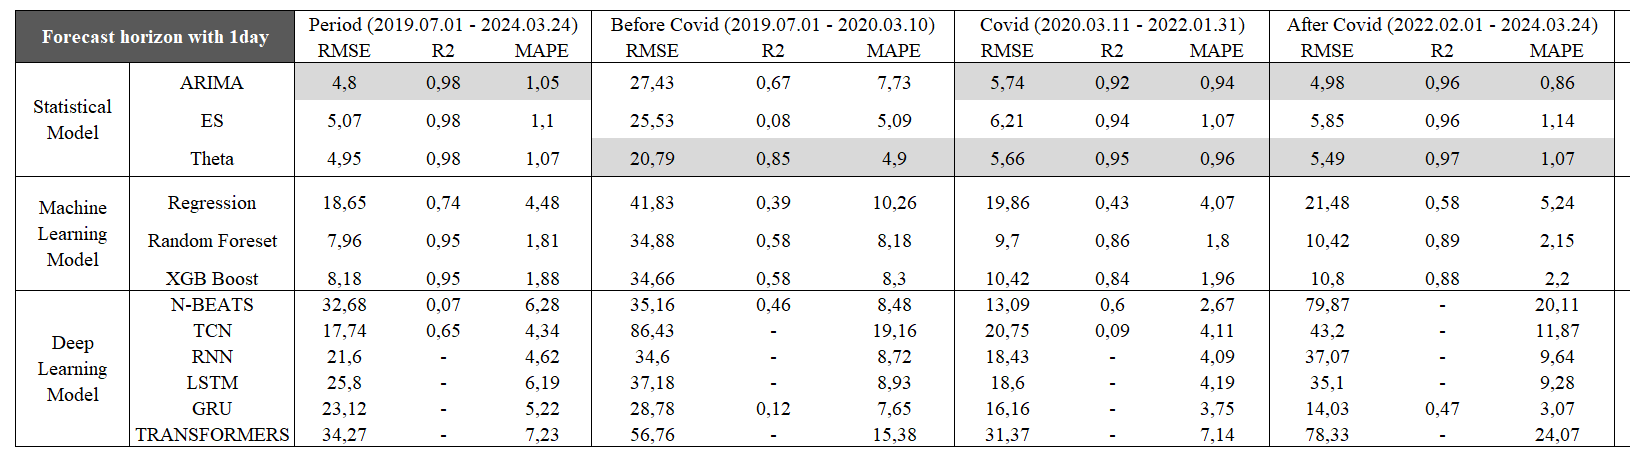

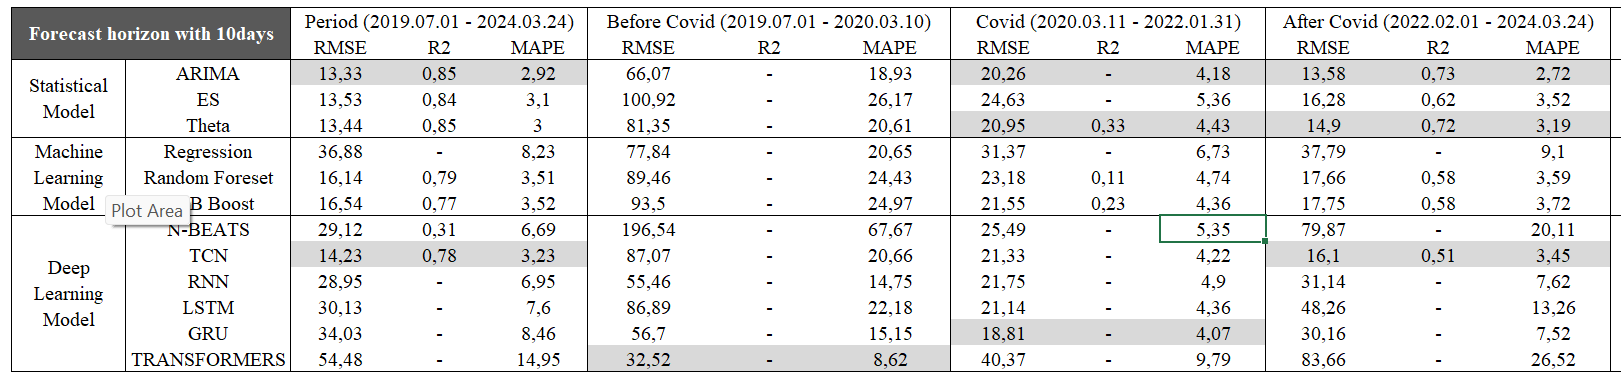

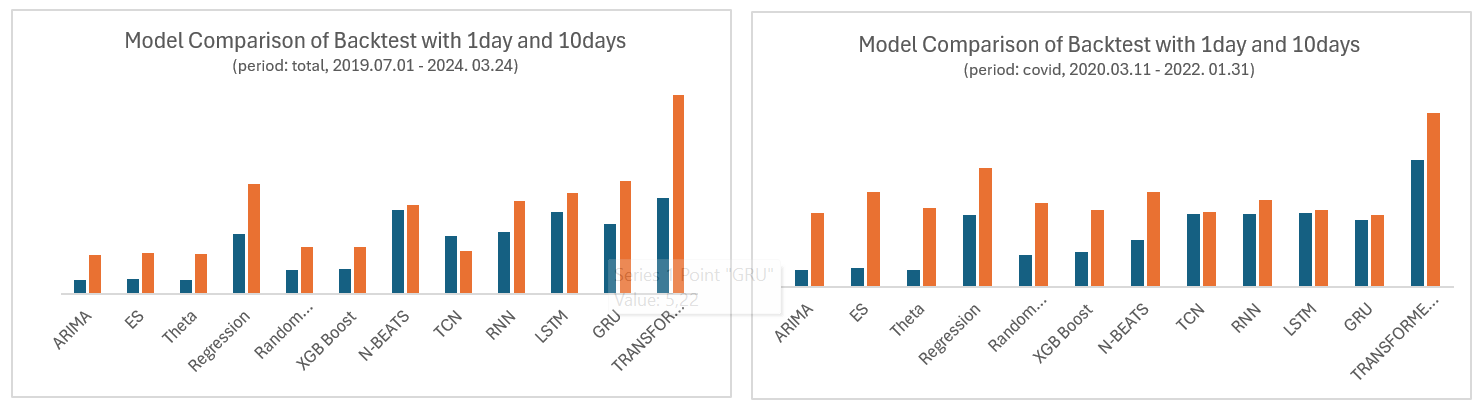

In [2]:
# data preparation
df = pd.read_csv(r"C:\Users\dicod\Documents\2024\project_with Hamid(2024_3rd semester)\code\final_df.csv")
df_price = df[['Date','Close']]
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price['Date'] = df_price['Date'].dt.strftime('%Y-%m-%d')
df_price['Date'] = df_price['Date'].apply(lambda x:x[0:10])
df_price['Date'] = pd.to_datetime(df_price['Date'])

# divide data which declared covid a pandemic on March 11, 2020.
df_price['Date'] = pd.to_datetime(df_price['Date'])

# define the covid date
covid_start = pd.to_datetime('2020-03-11')
covid_end = pd.to_datetime('2022-01-31')

# before
df_before_covid = df_price[df_price['Date'] < covid_start]

# covid
df_covid = df_price[(df_price['Date'] >= covid_start) & (df_price['Date'] <= covid_end)]

# after
df_after_covid = df_price[df_price['Date'] > covid_end]

print("before COVID-19:", df_before_covid)
print("COVID-19:", df_covid)
print("after COVID-19:", df_after_covid)

# Convert DataFrame to TimeSeries
ts_price = TimeSeries.from_dataframe(df_price, time_col=None , value_cols='Close', freq='D') # 2019.07.01 - 2024.03.24
ts_before_covid = TimeSeries.from_dataframe(df_before_covid, time_col="Date", value_cols='Close', fill_missing_dates=True, freq='D')
ts_covid = TimeSeries.from_dataframe(df_covid, time_col="Date", value_cols='Close', fill_missing_dates=False, freq='D')
ts_after_covid = TimeSeries.from_dataframe(df_after_covid, time_col="Date", value_cols='Close', fill_missing_dates=False, freq='D')

transformer = MissingValuesFiller()

ts_before_covid = transformer.transform(ts_before_covid)
ts_covid = transformer.transform(ts_covid)
ts_after_covid = transformer.transform(ts_after_covid)

before COVID-19:           Date       Close
0   2019-07-01  129.630859
1   2019-07-02  130.490692
2   2019-07-03  131.331482
3   2019-07-05  130.949295
4   2019-07-08  130.853775
..         ...         ...
170 2020-03-04  164.493134
171 2020-03-05  160.365189
172 2020-03-06  155.832062
173 2020-03-09  145.270950
174 2020-03-10  155.205170

[175 rows x 2 columns]
COVID-19:           Date       Close
175 2020-03-11  148.174042
176 2020-03-12  134.121506
177 2020-03-13  153.189392
178 2020-03-16  130.610748
179 2020-03-17  141.364746
..         ...         ...
648 2022-01-25  282.776947
649 2022-01-26  290.834198
650 2022-01-27  293.902222
651 2022-01-28  302.155518
652 2022-01-31  304.821625

[478 rows x 2 columns]
after COVID-19:            Date       Close
653  2022-02-01  302.645569
654  2022-02-02  307.252472
655  2022-02-03  295.284271
656  2022-02-04  299.881378
657  2022-02-07  294.990234
...         ...         ...
1187 2024-03-19  421.410004
1188 2024-03-20  425.230011
1189 2024

C:\Users\dicod\AppData\Local\Temp\ipykernel_19864\4027772170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = pd.to_datetime(df_price['Date'])
C:\Users\dicod\AppData\Local\Temp\ipykernel_19864\4027772170.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Date'] = df_price['Date'].dt.strftime('%Y-%m-%d')
C:\Users\dicod\AppData\Local\Temp\ipykernel_19864\4027772170.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

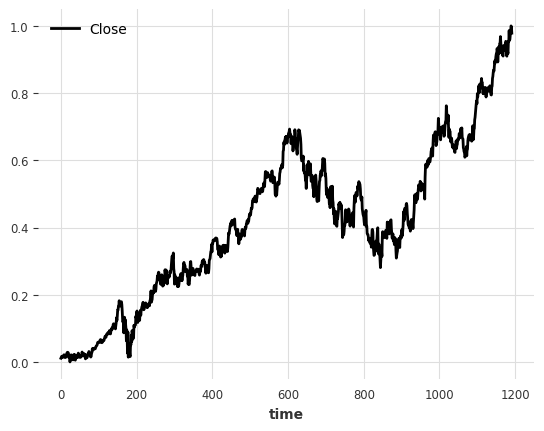

In [3]:
scaler = Scaler()
scaled_ts_price, scaled_ts_before_covid, scaled_ts_covid, scaled_ts_after_covid = scaler.fit_transform([ts_price, ts_before_covid, ts_covid, ts_after_covid])

# chart
scaled_ts_price.plot()

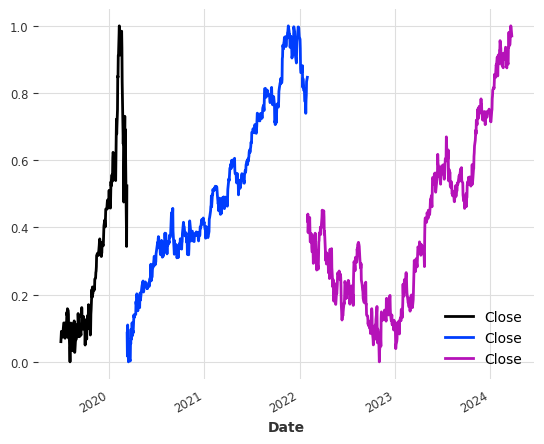

In [4]:
scaled_ts_before_covid.plot()
scaled_ts_covid.plot()
scaled_ts_after_covid.plot()

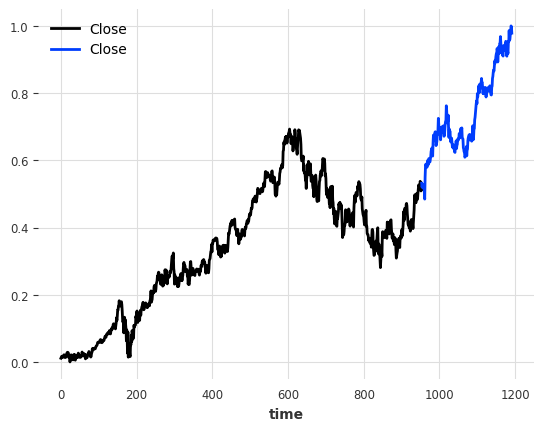

In [5]:
# data split the train and test
train, test = scaled_ts_price.split_after(0.8)
train_covid, test_covid = scaled_ts_covid.split_after(0.8)
train_before_covid, test_before_covid = scaled_ts_before_covid.split_after(0.8)
train_after_covid, test_after_covid = scaled_ts_after_covid.split_after(0.8)
train.plot()
test.plot()

### statistical model 
1. Arima model
- define the parameters, p0, d1, q0
- p is the number of autoregressive term from AR.
- d is differencing to make data stationary :  Arima models precondition is data should be stationary.
- q is the number of lagged forecast errors in the prediction equation from MA.

2. Exponential smoothing model
- check the pattern and seasonality


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


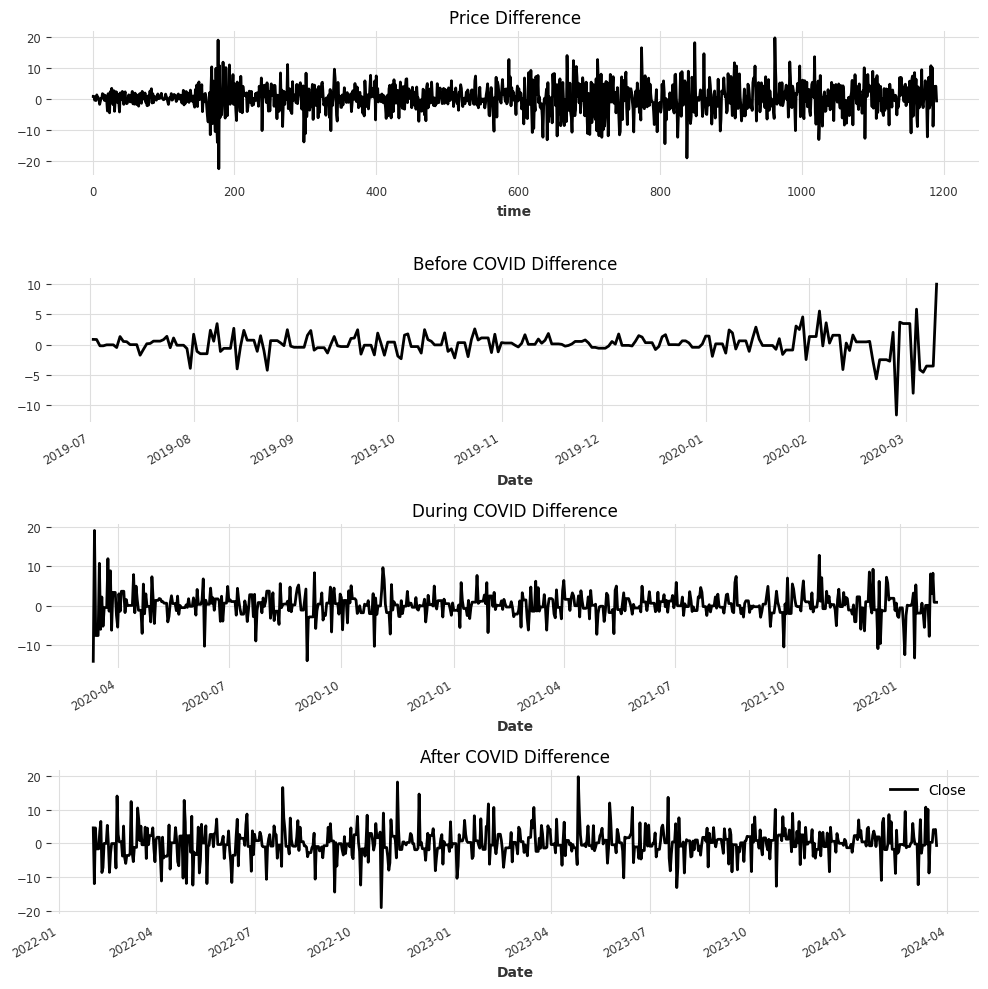

In [39]:
# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# Plot each TimeSeries
ts_price.diff().plot(ax=axes[0])
axes[0].set_title('Price Difference')

ts_before_covid.diff().plot(ax=axes[1])
axes[1].set_title('Before COVID Difference')

ts_covid.diff().plot(ax=axes[2])
axes[2].set_title('During COVID Difference')

ts_after_covid.diff().plot(ax=axes[3])
axes[3].set_title('After COVID Difference')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


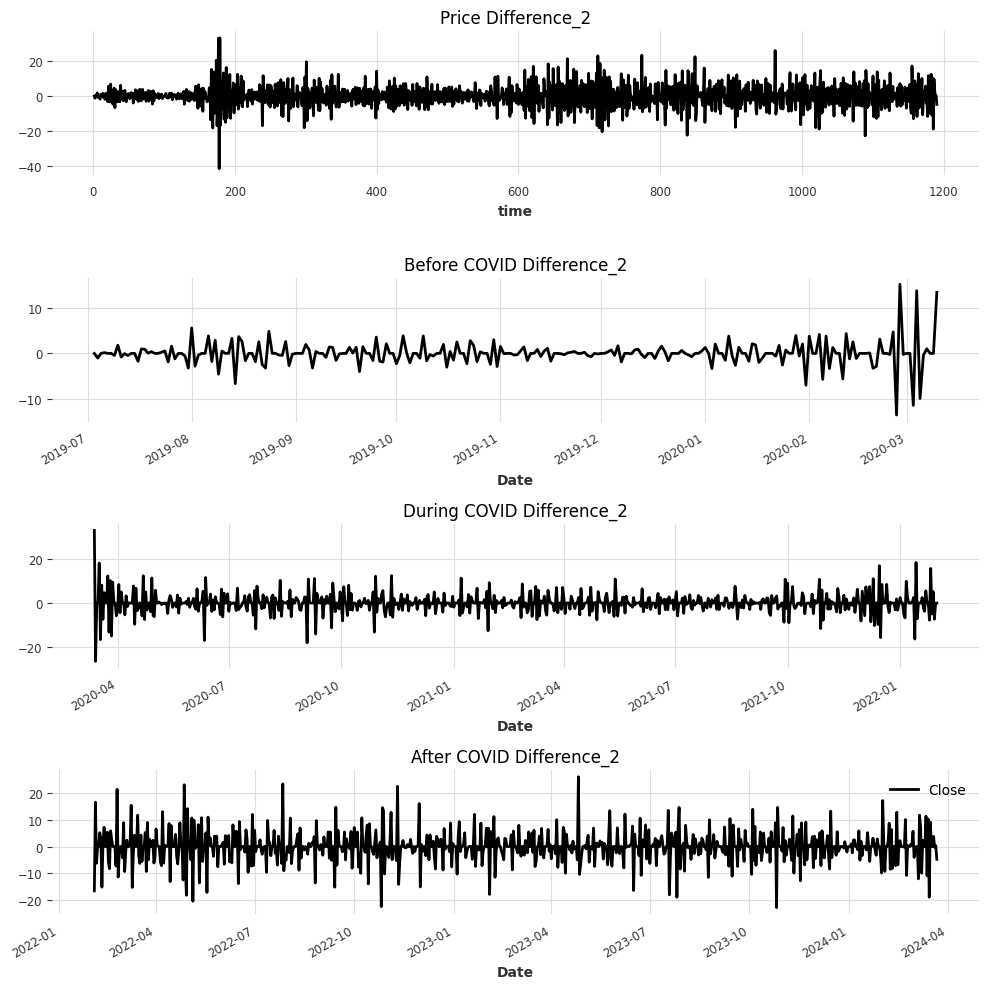

In [40]:
# diff_2

# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# Plot each TimeSeries
ts_price.diff().diff().plot(ax=axes[0])
axes[0].set_title('Price Difference_2')

ts_before_covid.diff().diff().plot(ax=axes[1])
axes[1].set_title('Before COVID Difference_2')

ts_covid.diff().diff().plot(ax=axes[2])
axes[2].set_title('During COVID Difference_2')

ts_after_covid.diff().diff().plot(ax=axes[3])
axes[3].set_title('After COVID Difference_2')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

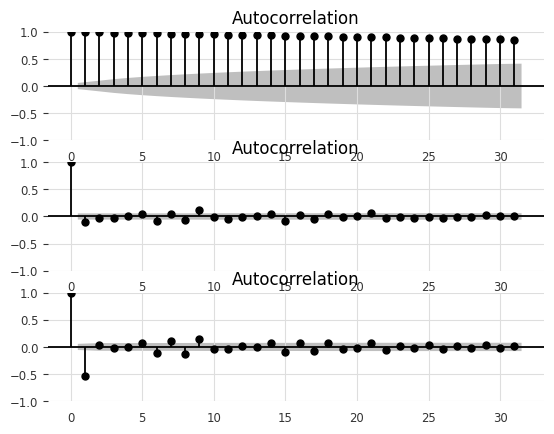

In [47]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_price['Close'], ax=ax1)
plot_acf(df_price['Close'].diff().dropna(), ax=ax2)
plot_acf(df_price['Close'].diff().diff().dropna(), ax=ax3)
#plot_acfts_after_covid
plt.show()
# from the ACF chart we find out data's ARp = 0

<function matplotlib.pyplot.show(close=None, block=None)>

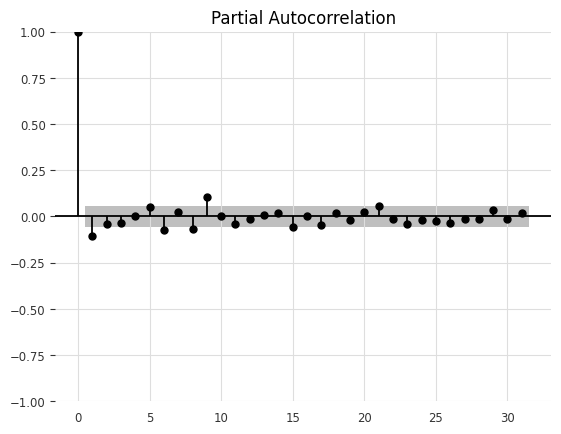

In [48]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_price['Close'].diff().dropna())
plt.show

# from the chart we decide our data has no relationship with previous data, this indicates MAq=0, 

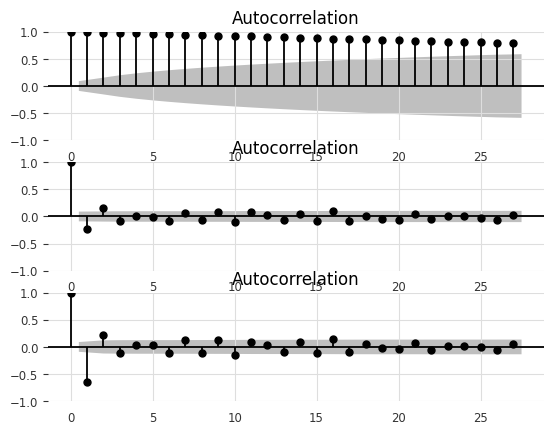

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_covid['Close'], ax=ax1)
plot_acf(df_covid['Close'].diff().dropna(), ax=ax2)
plot_acf(df_covid['Close'].diff().diff().dropna(), ax=ax3)
plt.show()

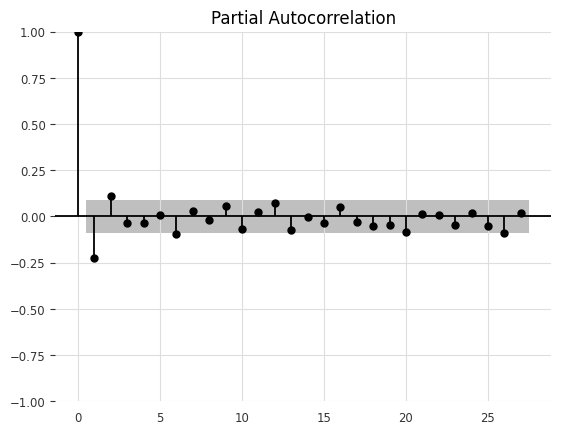

In [52]:
plot_pacf(df_covid['Close'].diff().dropna())
plt.show() # covid period  q =1 

# data split the train and test
train, test = scaled_ts_price.split_after0.8
train_covid, test_covid = scaled_ts_covid.split_after0.8
train_before_covid, test_before_covid = scaled_ts_before_covid.split_after0.8
train_after_covid, test_after_covid = scaled_ts_after_covid.split_after0.8

In [6]:
from darts.models import ARIMA
from darts.metrics import mape, rmse, r2_score

# define model
arima = ARIMA(p=0, d=1, q=0)

# With total period data
data = test
arima.fit(train)
pred_price = arima.historical_forecasts(series=data)

# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

days_10 = arima.predict(10)
days_10 = scaler.inverse_transform(days_10)


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [21]:
# implementation ARIMA model #time: 7.3s
from darts.models import ARIMA
from darts.metrics import mape, rmse, r2_score

# define model
arima = ARIMA(p=0, d=1, q=0)

# With total period data
data = test
arima.fit(train)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=30)

# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

# Evaluation
#arima_rmse = rmsetest, pred_price
#arima__r2 = r2_scoretest, pred_price
#arima_mape = mapetest, pred_price

print("ARIMA_RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA_R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA_MAPE = %.2f" % mape(data, pred_price))

#plt.figurefigsize=20, 5, dpi=80
#test['Close'].plotlabel="actual"
#pred_price.plotlabel="predict"
#plt.show

# with before covid data
data = test_before_covid
arima.fit(train_before_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=30)

# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA_before covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA_before covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA_before covid MAPE = %.2f" % mape(data, pred_price))

# With covid data
data = test_covid
arima.fit(train_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=30)
# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA covid MAPE = %.2f" % mape(data, pred_price))

# With after
data = test_after_covid
arima.fit(train_after_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=30)
# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA after covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA after covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA after covid MAPE = %.2f" % mape(data, pred_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA_RMSE = 24.80
ARIMA_R2 = 0.49
ARIMA_MAPE = 5.21
ARIMA_before covid RMSE = nan
ARIMA_before covid R2 = nan
ARIMA_before covid MAPE = nan


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\metrics\metrics.py:1052: RuntimeWarning: Mean of empty slice.
  y_hat = y1.mean()
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\metrics\metrics.py:1054: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ss_errors / ss_tot
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Li

ARIMA covid RMSE = 32.42
ARIMA covid R2 = -1.29
ARIMA covid MAPE = 6.77


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA after covid RMSE = 26.50
ARIMA after covid R2 = -0.21
ARIMA after covid MAPE = 5.19


In [6]:
# implementation ARIMA model #time: 7.3s
from darts.models import ARIMA
from darts.metrics import mape, rmse, r2_score

# define model
arima = ARIMA(p=0, d=1, q=0)

# With total period data
data = test
arima.fit(train)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=10)

# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

# Evaluation
#arima_rmse = rmsetest, pred_price
#arima__r2 = r2_scoretest, pred_price
#arima_mape = mapetest, pred_price

print("ARIMA_RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA_R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA_MAPE = %.2f" % mape(data, pred_price))

#plt.figurefigsize=20, 5, dpi=80
#test['Close'].plotlabel="actual"
#pred_price.plotlabel="predict"
#plt.show

# with before covid data
data = test_before_covid
arima.fit(train_before_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=10)

# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA_before covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA_before covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA_before covid MAPE = %.2f" % mape(data, pred_price))

# With covid data
data = test_covid
arima.fit(train_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=10)
# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA covid MAPE = %.2f" % mape(data, pred_price))

# With after
data = test_after_covid
arima.fit(train_after_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=10)
# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA after covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA after covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA after covid MAPE = %.2f" % mape(data, pred_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA_RMSE = 13.33
ARIMA_R2 = 0.85
ARIMA_MAPE = 2.92


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA_before covid RMSE = 66.07
ARIMA_before covid R2 = -2.94
ARIMA_before covid MAPE = 18.93


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA covid RMSE = 20.26
ARIMA covid R2 = -0.01
ARIMA covid MAPE = 4.18


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA after covid RMSE = 13.58
ARIMA after covid R2 = 0.73
ARIMA after covid MAPE = 2.72


In [13]:
from darts.models import ARIMA
from darts.metrics import mape, rmse, r2_score

# define model
arima = ARIMA(p=0, d=1, q=0)

# With total period data
data = test
arima.fit(train)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=1)

# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

# Evaluation
#arima_rmse = rmsetest, pred_price
#arima__r2 = r2_scoretest, pred_price
#arima_mape = mapetest, pred_price

print("ARIMA_RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA_R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA_MAPE = %.2f" % mape(data, pred_price))

#plt.figurefigsize=20, 5, dpi=80
#test['Close'].plotlabel="actual"
#pred_price.plotlabel="predict"
#plt.show

# with before covid data
data = test_before_covid
arima.fit(train_before_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=1)

# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA_before covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA_before covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA_before covid MAPE = %.2f" % mape(data, pred_price))

# With covid data
data = test_covid
arima.fit(train_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=1)
# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA covid MAPE = %.2f" % mape(data, pred_price))

# With after
data = test_after_covid
arima.fit(train_after_covid)
pred_price = arima.historical_forecasts(series=data, forecast_horizon=1)
# scaler inverse
pred_price = scaler.inverse_transform(pred_price)
data = scaler.inverse_transform(data)

print("ARIMA after covid RMSE = %.2f" % rmse(data, pred_price))
print("ARIMA after covid R2 = %.2f" % r2_score(data, pred_price))
print("ARIMA after covid MAPE = %.2f" % mape(data, pred_price))

c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA_RMSE = 4.80
ARIMA_R2 = 0.98
ARIMA_MAPE = 1.05


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA_before covid RMSE = 27.43
ARIMA_before covid R2 = 0.67
ARIMA_before covid MAPE = 7.73


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA covid RMSE = 5.74
ARIMA covid R2 = 0.92
ARIMA covid MAPE = 0.94


c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

ARIMA after covid RMSE = 4.96
ARIMA after covid R2 = 0.96
ARIMA after covid MAPE = 0.86


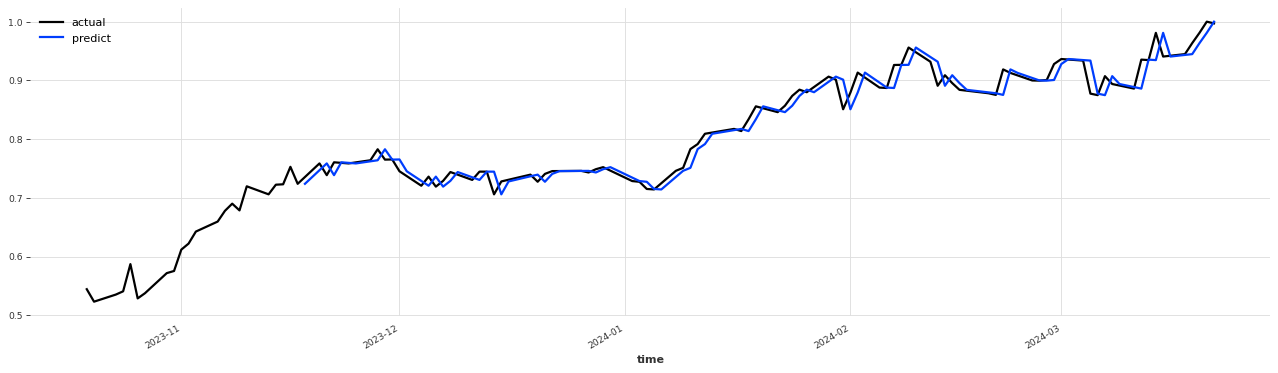

In [54]:
plt.figure(figsize=(20, 5), dpi=80)
plt.title('Arima Model Prediction')
test_after_covid['Close'].plot(label="actual")
pred_price.plot(label="predict")
plt.show()

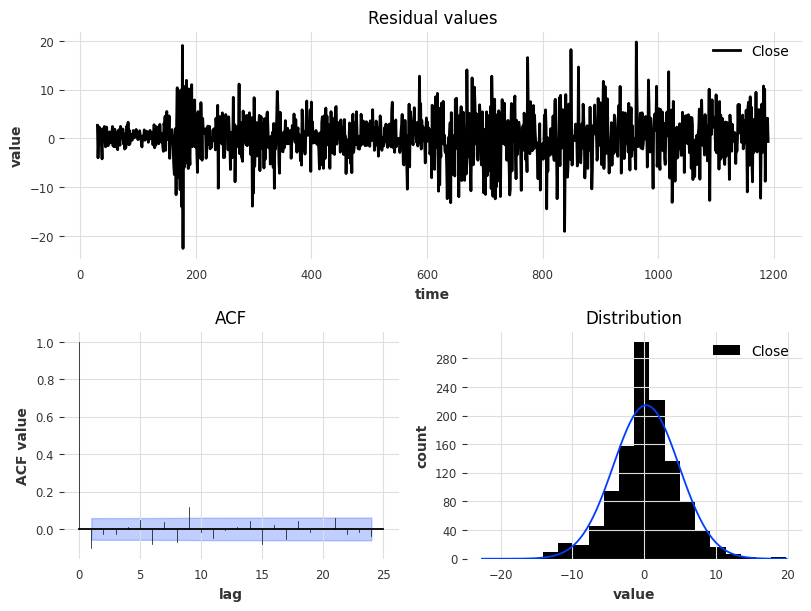

In [58]:
# model evaluation

from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(arima.residuals(ts_price))

In [7]:
# forecast horizon with 10
from darts.models import ExponentialSmoothing, Theta
# with total
def eval_model(model):
    data = test
    model.fit(train)
    forecast = model.historical_forecasts(series=data, forecast_horizon=10)
    # scaler inverse
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

# with before covid
def eval_model(model):
    data = test_before_covid
    model.fit(train_before_covid)
    forecast = model.historical_forecasts(series=data, forecast_horizon=10)
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} Before Covid RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} Before Covid R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} Before Covid MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

# with covid
def eval_model(model):
    data = test_covid
    model.fit(train_covid)
    forecast = model.historical_forecasts(series=data, forecast_horizon=10)
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} Covid RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} Covid R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} Covid MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

# with after covid
def eval_model(model):
    data = test_after_covid
    model.fit(train_after_covid)
    forecast = model.historical_forecasts(series=data, forecast_horizon=10)
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} After Covid RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} After Covid R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} After Covid MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

ExponentialSmoothing() RMSE: 13.53
ExponentialSmoothing() R2: 0.84%
ExponentialSmoothing() MAPE: 3.10%
Theta() RMSE: 13.44
Theta() R2: 0.85%
Theta() MAPE: 3.00%
ExponentialSmoothing() Before Covid RMSE: 100.92
ExponentialSmoothing() Before Covid R2: -2.05%
ExponentialSmoothing() Before Covid MAPE: 26.17%
Theta() Before Covid RMSE: 81.35
Theta() Before Covid R2: -1.12%
Theta() Before Covid MAPE: 20.61%
ExponentialSmoothing() Covid RMSE: 24.63
ExponentialSmoothing() Covid R2: -0.21%
ExponentialSmoothing() Covid MAPE: 5.36%
Theta() Covid RMSE: 20.95
Theta() Covid R2: 0.33%
Theta() Covid MAPE: 4.43%
ExponentialSmoothing() After Covid RMSE: 16.28
ExponentialSmoothing() After Covid R2: 0.62%
ExponentialSmoothing() After Covid MAPE: 3.52%
Theta() After Covid RMSE: 14.90
Theta() After Covid R2: 0.72%
Theta() After Covid MAPE: 3.19%


In [14]:
from darts.models import ExponentialSmoothing, Theta
# with total
def eval_model(model):
    data = test
    model.fit(train)
    forecast = model.historical_forecasts(series=data, forecast_horizon=1)
    # scaler inverse
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

# with before covid
def eval_model(model):
    data = test_before_covid
    model.fit(train_before_covid)
    forecast = model.historical_forecasts(series=data, forecast_horizon=1)
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} Before Covid RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} Before Covid R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} Before Covid MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

# with covid
def eval_model(model):
    data = test_covid
    model.fit(train_covid)
    forecast = model.historical_forecasts(series=data, forecast_horizon=1)
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} Covid RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} Covid R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} Covid MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

# with after covid
def eval_model(model):
    data = test_after_covid
    model.fit(train_after_covid)
    forecast = model.historical_forecasts(series=data, forecast_horizon=1)
    forecast = scaler.inverse_transform(forecast)
    data = scaler.inverse_transform(data)
    print("{} After Covid RMSE: {:.2f}".format(model, rmse(data, forecast)))
    print("{} After Covid R2: {:.2f}%".format(model, r2_score(data, forecast)))
    print("{} After Covid MAPE: {:.2f}%".format(model, mape(data, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Theta())

ExponentialSmoothing() RMSE: 5.07
ExponentialSmoothing() R2: 0.98%
ExponentialSmoothing() MAPE: 1.10%
Theta() RMSE: 4.96
Theta() R2: 0.98%
Theta() MAPE: 1.08%
ExponentialSmoothing() Before Covid RMSE: 25.53
ExponentialSmoothing() Before Covid R2: 0.80%
ExponentialSmoothing() Before Covid MAPE: 5.90%
Theta() Before Covid RMSE: 20.79
Theta() Before Covid R2: 0.85%
Theta() Before Covid MAPE: 4.90%
ExponentialSmoothing() Covid RMSE: 6.21
ExponentialSmoothing() Covid R2: 0.94%
ExponentialSmoothing() Covid MAPE: 1.07%
Theta() Covid RMSE: 5.66
Theta() Covid R2: 0.95%
Theta() Covid MAPE: 0.96%
ExponentialSmoothing() After Covid RMSE: 5.53
ExponentialSmoothing() After Covid R2: 0.96%
ExponentialSmoothing() After Covid MAPE: 1.08%
Theta() After Covid RMSE: 5.36
Theta() After Covid R2: 0.97%
Theta() After Covid MAPE: 1.03%


### machine learning- SVM, RF, linear

In [8]:
# forecast horizon with 10 days
from darts.models import RegressionModel # time : 0.6s
from sklearn.linear_model import Ridge

# With total
data = test
regression = RegressionModel(model=Ridge(), lags=1, output_chunk_length=2)
regression.fit(train)
pred = regression.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)

print("regression RMSE = %.2f" % rmse(data, pred))
print("regression R2 = %.2f" % r2_score(data, pred))
print("regression MAPE = %.2f" % mape(data, pred))

# with before covid
data = test_before_covid
regression.fit(train_before_covid)
pred = regression.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("regression before covid RMSE = %.2f" % rmse(data, pred))
print("regression before covid R2 = %.2f" % r2_score(data, pred))
print("regression before covid MAPE = %.2f" % mape(data, pred))

# with covid
data = test_covid
regression.fit(train_covid)
pred = regression.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("regression covid RMSE = %.2f" % rmse(data, pred))
print("regression covid R2 = %.2f" % r2_score(data, pred))
print("regression covid MAPE = %.2f" % mape(data, pred))

# with after covid
data = test_after_covid
regression.fit(train_after_covid)
pred = regression.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("regression after covid RMSE = %.2f" % rmse(data, pred))
print("regression after covid R2 = %.2f" % r2_score(data, pred))
print("regression after covid MAPE = %.2f" % mape(data, pred))

regression RMSE = 36.88
regression R2 = -0.10
regression MAPE = 8.23
regression before covid RMSE = 77.84
regression before covid R2 = -0.94
regression before covid MAPE = 20.65
regression covid RMSE = 31.07
regression covid R2 = -0.46
regression covid MAPE = 6.73
regression after covid RMSE = 37.79
regression after covid R2 = -0.80
regression after covid MAPE = 9.10


In [11]:
# random forest model
from darts.models import RandomForest

rf = RandomForest(
    lags=1,
    output_chunk_length=5,
    n_estimators=100,
    criterion="absolute_error")

# total
data = test
rf.fit(train)
pred = rf.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("rf RMSE = %.2f" % rmse(data, pred))
print("rf R2 = %.2f" % r2_score(data, pred))
print("rf MAPE = %.2f" % mape(data, pred))

# before covid
data = test_before_covid
rf.fit(train_before_covid)
pred = rf.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("rf before covid RMSE = %.2f" % rmse(data, pred))
print("rf before covid R2 = %.2f" % r2_score(data, pred))
print("rf before covid MAPE = %.2f" % mape(data, pred))

# covid
data = test_covid
rf.fit(train_covid)
pred = rf.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("rf covid RMSE = %.2f" % rmse(data, pred))
print("rf covid R2 = %.2f" % r2_score(data, pred))
print("rf covid MAPE = %.2f" % mape(data, pred))

# after covid
data = test_after_covid
rf.fit(train_after_covid)
pred = rf.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("rf after covid RMSE = %.2f" % rmse(data, pred))
print("rf after covid R2 = %.2f" % r2_score(data, pred))
print("rf after covid MAPE = %.2f" % mape(data, pred))


rf RMSE = 16.14
rf R2 = 0.79
rf MAPE = 3.51
rf before covid RMSE = 89.46
rf before covid R2 = -1.38
rf before covid MAPE = 24.43
rf covid RMSE = 23.18
rf covid R2 = 0.11
rf covid MAPE = 4.74
rf after covid RMSE = 17.66
rf after covid R2 = 0.58
rf after covid MAPE = 3.59


In [12]:
from darts.models import XGBModel

XGB = XGBModel(
    lags=1,
    output_chunk_length=5)


# total
data = test
XGB.fit(train)
pred = XGB.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("XGB RMSE = %.2f" % rmse(data, pred))
print("XGB R2 = %.2f" % r2_score(data, pred))
print("XGB MAPE = %.2f" % mape(data, pred))

# before covid
data = test_before_covid
XGB.fit(train_before_covid)
pred = XGB.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("XGB RMSE = %.2f" % rmse(data, pred))
print("XGB R2 = %.2f" % r2_score(data, pred))
print("XGB MAPE = %.2f" % mape(data, pred))

# covid
data = test_covid
XGB.fit(train_covid)
pred = XGB.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("XGB covid RMSE = %.2f" % rmse(data, pred))
print("XGB covid R2 = %.2f" % r2_score(data, pred))
print("XGB covid MAPE = %.2f" % mape(data, pred))

# after covid
data = test_after_covid
XGB.fit(train_after_covid)
pred = XGB.historical_forecasts(series=data, forecast_horizon =10)
pred = scaler.inverse_transform(pred)
data = scaler.inverse_transform(data)
print("XGB after covid RMSE = %.2f" % rmse(data, pred))
print("XGB after covid R2 = %.2f" % r2_score(data, pred))
print("XGB after covid MAPE = %.2f" % mape(data, pred))

XGB RMSE = 16.54
XGB R2 = 0.77
XGB MAPE = 3.52
XGB RMSE = 93.50
XGB R2 = -1.60
XGB MAPE = 24.97
XGB covid RMSE = 21.55
XGB covid R2 = 0.23
XGB covid MAPE = 4.36
XGB after covid RMSE = 17.75
XGB after covid R2 = 0.58
XGB after covid MAPE = 3.72


# Neural Network

In [12]:
# n-beats

from darts.models import NBEATSModel
NBEATS = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=6, num_blocks=5, num_layers=4,
    n_epochs=50,
    activation='LeakyReLU')


# total
data = test
NBEATS.fit(train)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS MAPE = %.2f" % mape(data, pred_price))

# before covid
data = test_before_covid
NBEATS.fit(train_before_covid)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS before covid RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS before covid R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS before covid MAPE = %.2f" % mape(data, pred_price))

# covid
data = test_covid
NBEATS.fit(train_covid)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS covid RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS covid R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS covid MAPE = %.2f" % mape(data, pred_price))

# After covid
data = test_after_covid
NBEATS.fit(train_after_covid)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS After covid RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS After covid R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS After covid MAPE = %.2f" % mape(data, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS RMSE = 28.12
NBEATS R2 = 0.31
NBEATS MAPE = 6.69


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS before covid RMSE = 196.54
NBEATS before covid R2 = -33.89
NBEATS before covid MAPE = 67.67


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS covid RMSE = 25.49
NBEATS covid R2 = -0.59
NBEATS covid MAPE = 5.35


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS After covid RMSE = 79.87
NBEATS After covid R2 = -8.65
NBEATS After covid MAPE = 20.11


In [15]:
# n-beats

from darts.models import NBEATSModel
NBEATS = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    generic_architecture=True, num_stacks=6, num_blocks=5, num_layers=4,
    n_epochs=50,
    activation='LeakyReLU')


# total
data = test
NBEATS.fit(train)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS MAPE = %.2f" % mape(data, pred_price))

# before covid
data = test_before_covid
NBEATS.fit(train_before_covid)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS before covid RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS before covid R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS before covid MAPE = %.2f" % mape(data, pred_price))

# covid
data = test_covid
NBEATS.fit(train_covid)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS covid RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS covid R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS covid MAPE = %.2f" % mape(data, pred_price))

# After covid
data = test_after_covid
NBEATS.fit(train_after_covid)
NBEATS_pred_series = NBEATS.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)
pred_price = scaler.inverse_transform(NBEATS_pred_series)
data = scaler.inverse_transform(data)

print("NBEATS After covid RMSE = %.2f" % rmse(data, pred_price))
print("NBEATS After covid R2 = %.2f" % r2_score(data, pred_price))
print("NBEATS After covid MAPE = %.2f" % mape(data, pred_price))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS RMSE = 32.68
NBEATS R2 = 0.07
NBEATS MAPE = 6.28


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS before covid RMSE = 35.16
NBEATS before covid R2 = 0.46
NBEATS before covid MAPE = 8.48



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS covid RMSE = 13.09
NBEATS covid R2 = 0.60
NBEATS covid MAPE = 2.67



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

NBEATS After covid RMSE = 31.91
NBEATS After covid R2 = -0.48
NBEATS After covid MAPE = 7.66


In [27]:
from darts.models import TCNModel,NBEATSModel,TransformerModel,BlockRNNModel

In [22]:
# TCN
TCN = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=5, dilation_base=3, weight_norm=True,
    n_epochs=50) #dropout=0.01)


# total
data = test
TCN.fit(train)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=30,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN RMSE = %.2f" % rmse(pred_price, data))
print("TCN R2 = %.2f" % r2_score(pred_price, data))
print("TCN MAPE = %.2f" % mape(pred_price, data))

# before covid
data = test_before_covid
TCN.fit(train_before_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=30,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN before covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN before covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
TCN.fit(train_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=30,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN covid MAPE = %.2f" % mape(pred_price, data))

# after covid
data = test_after_covid
TCN.fit(train_after_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=30,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN after covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN after covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN after covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 631   
----------------------------------------------------
631       Trainable params
0         Non-trainable params
631       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN RMSE = 48.47
TCN R2 = -139.17
TCN MAPE = 11.58


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\darts\metrics\metrics.py:1052: RuntimeWarning: Mean of empty slice.
  y_hat = y1.mean()
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\dicod\AppData\Local\Programs\Python\Python311\Li

TCN before covid RMSE = nan
TCN before covid R2 = nan
TCN before covid MAPE = nan


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN covid RMSE = 32.90
TCN covid R2 = -107.50
TCN covid MAPE = 7.45


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN after covid RMSE = 87.91
TCN after covid R2 = -327.00
TCN after covid MAPE = 28.14


In [16]:
# TCN
TCN = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=5, dilation_base=3, weight_norm=True,
    n_epochs=50) #dropout=0.01)


# total
data = test
TCN.fit(train)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=1,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN RMSE = %.2f" % rmse(pred_price, data))
print("TCN R2 = %.2f" % r2_score(pred_price, data))
print("TCN MAPE = %.2f" % mape(pred_price, data))

# before covid
data = test_before_covid
TCN.fit(train_before_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=1,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN before covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN before covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
TCN.fit(train_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=1,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN covid MAPE = %.2f" % mape(pred_price, data))

# after covid
data = test_after_covid
TCN.fit(train_after_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=1,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN after covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN after covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN after covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 631   
----------------------------------------------------
631       Trainable params
0         Non-trainable params
631       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN RMSE = 17.74
TCN R2 = 0.65
TCN MAPE = 4.34


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN before covid RMSE = 86.43
TCN before covid R2 = -2.24
TCN before covid MAPE = 19.16


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN covid RMSE = 20.75
TCN covid R2 = 0.09
TCN covid MAPE = 4.11


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN after covid RMSE = 43.20
TCN after covid R2 = -7.95
TCN after covid MAPE = 11.87


In [14]:
# TCN
TCN = TCNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    kernel_size=4, num_filters=4, num_layers=5, dilation_base=3, weight_norm=True,
    n_epochs=50) #dropout=0.01)


# total
data = test
TCN.fit(train)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=10,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN RMSE = %.2f" % rmse(pred_price, data))
print("TCN R2 = %.2f" % r2_score(pred_price, data))
print("TCN MAPE = %.2f" % mape(pred_price, data))

# before covid
data = test_before_covid
TCN.fit(train_before_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=10,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN before covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN before covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
TCN.fit(train_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=10,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN covid MAPE = %.2f" % mape(pred_price, data))

# after covid
data = test_after_covid
TCN.fit(train_after_covid)
TCN_pred_series = TCN.historical_forecasts(
    series=data,
    forecast_horizon=10,
    retrain=False,
    verbose=False)

pred_price = scaler.inverse_transform(TCN_pred_series)
data = scaler.inverse_transform(data)

print("TCN after covid RMSE = %.2f" % rmse(pred_price, data))
print("TCN after covid R2 = %.2f" % r2_score(pred_price, data))
print("TCN after covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 631   
----------------------------------------------------
631       Trainable params
0         Non-trainable params
631       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN RMSE = 14.23
TCN R2 = 0.78
TCN MAPE = 3.23


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN before covid RMSE = 87.07
TCN before covid R2 = -2.30
TCN before covid MAPE = 20.66


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN covid RMSE = 21.33
TCN covid R2 = -0.23
TCN covid MAPE = 4.22


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

TCN after covid RMSE = 16.10
TCN after covid R2 = 0.51
TCN after covid MAPE = 3.45


In [17]:
# RNN
rnn_3 = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="RNN",
    hidden_dim=15, # hidden vector dimension
    n_rnn_layers=3,
    n_epochs=50)


# total
data = test
rnn_3.fit(train)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)
print("RNN RMSE = %.2f" % rmse(pred_price, data))
print("RNN R2 = %.2f" % r2_score(pred_price, data))
print("RNN MAPE = %.2f" % mape(pred_price, data))

# before covid
data = test_before_covid
rnn_3.fit(train_before_covid)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)

print("RNN before covid RMSE = %.2f" % rmse(pred_price, data))
print("RNN before covid R2 = %.2f" % r2_score(pred_price, data))
print("RNN before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
rnn_3.fit(train_covid)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)

print("RNN covid RMSE = %.2f" % rmse(pred_price, data))
print("RNN covid R2 = %.2f" % r2_score(pred_price, data))
print("RNN covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
rnn_3.fit(train_after_covid)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)

print("RNN After covid RMSE = %.2f" % rmse(pred_price, data))
print("RNN After covid R2 = %.2f" % r2_score(pred_price, data))
print("RNN After covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 160   
---------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN RMSE = 21.60
RNN R2 = -0.17
RNN MAPE = 4.62


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN before covid RMSE = 34.60
RNN before covid R2 = -1.75
RNN before covid MAPE = 8.72


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN covid RMSE = 18.43
RNN covid R2 = -1.32
RNN covid MAPE = 4.09


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN After covid RMSE = 37.07
RNN After covid R2 = -9.92
RNN After covid MAPE = 9.64


In [15]:
# RNN
rnn_3 = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="RNN",
    hidden_dim=15, # hidden vector dimension
    n_rnn_layers=3,
    n_epochs=50)


# total
data = test
rnn_3.fit(train)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)
print("RNN RMSE = %.2f" % rmse(pred_price, data))
print("RNN R2 = %.2f" % r2_score(pred_price, data))
print("RNN MAPE = %.2f" % mape(pred_price, data))

# before covid
data = test_before_covid
rnn_3.fit(train_before_covid)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)

print("RNN before covid RMSE = %.2f" % rmse(pred_price, data))
print("RNN before covid R2 = %.2f" % r2_score(pred_price, data))
print("RNN before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
rnn_3.fit(train_covid)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)

print("RNN covid RMSE = %.2f" % rmse(pred_price, data))
print("RNN covid R2 = %.2f" % r2_score(pred_price, data))
print("RNN covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
rnn_3.fit(train_after_covid)
pred_rnnseries_3 = rnn_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_rnnseries_3)
data = scaler.inverse_transform(data)

print("RNN After covid RMSE = %.2f" % rmse(pred_price, data))
print("RNN After covid R2 = %.2f" % r2_score(pred_price, data))
print("RNN After covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 160   
---------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN RMSE = 28.95
RNN R2 = -1.63
RNN MAPE = 6.95


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 1.2 K 
4 | fc            | Sequential       | 160   
---------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN before covid RMSE = 55.46
RNN before covid R2 = -8.11
RNN before covid MAPE = 14.75


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN covid RMSE = 21.75
RNN covid R2 = -2.35
RNN covid MAPE = 4.90


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

RNN After covid RMSE = 31.14
RNN After covid R2 = -4.30
RNN After covid MAPE = 7.62


In [18]:
#LSTM
LSTM_3 = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="LSTM",
    hidden_dim=15,
    n_rnn_layers=3,
    n_epochs=50)


# total
data = test
LSTM_3.fit(train)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)


pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM RMSE = %.2f" % rmse(pred_price, data))
print("LSTM R2 = %.2f" % r2_score(pred_price, data))
print("LSTM MAPE = %.2f" % mape(pred_price, data))

# Before covid
data = test_before_covid
LSTM_3.fit(train_before_covid)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM Before covid RMSE = %.2f" % rmse(pred_price, data))
print("LSTM Before covid R2 = %.2f" % r2_score(pred_price, data))
print("LSTM Before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
LSTM_3.fit(train_covid)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM covid RMSE = %.2f" % rmse(pred_price, data))
print("LSTM covid R2 = %.2f" % r2_score(pred_price, data))
print("LSTM covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
LSTM_3.fit(train_after_covid)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM After covid RMSE = %.2f" % rmse(pred_price, data))
print("LSTM After covid R2 = %.2f" % r2_score(pred_price, data))
print("LSTM After covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.9 K 
4 | fc            | Sequential       | 160   
---------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM RMSE = 25.80
LSTM R2 = -0.54
LSTM MAPE = 6.19


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM Before covid RMSE = 37.18
LSTM Before covid R2 = -2.53
LSTM Before covid MAPE = 8.93


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM covid RMSE = 18.60
LSTM covid R2 = -2.04
LSTM covid MAPE = 4.19


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM After covid RMSE = 35.10
LSTM After covid R2 = -5.12
LSTM After covid MAPE = 9.28


In [16]:
#LSTM
LSTM_3 = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="LSTM",
    hidden_dim=15,
    n_rnn_layers=3,
    n_epochs=50)


# total
data = test
LSTM_3.fit(train)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)


pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM RMSE = %.2f" % rmse(pred_price, data))
print("LSTM R2 = %.2f" % r2_score(pred_price, data))
print("LSTM MAPE = %.2f" % mape(pred_price, data))

# Before covid
data = test_before_covid
LSTM_3.fit(train_before_covid)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM Before covid RMSE = %.2f" % rmse(pred_price, data))
print("LSTM Before covid R2 = %.2f" % r2_score(pred_price, data))
print("LSTM Before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
LSTM_3.fit(train_covid)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM covid RMSE = %.2f" % rmse(pred_price, data))
print("LSTM covid R2 = %.2f" % r2_score(pred_price, data))
print("LSTM covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
LSTM_3.fit(train_after_covid)
pred_LSTM_series_3 = LSTM_3.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_LSTM_series_3)
data = scaler.inverse_transform(data)

# Evaluation
print("LSTM After covid RMSE = %.2f" % rmse(pred_price, data))
print("LSTM After covid R2 = %.2f" % r2_score(pred_price, data))
print("LSTM After covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.9 K 
4 | fc            | Sequential       | 160   
---------------------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM RMSE = 30.13
LSTM R2 = -1.07
LSTM MAPE = 7.60


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM Before covid RMSE = 86.89
LSTM Before covid R2 = -25.85
LSTM Before covid MAPE = 22.18


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM covid RMSE = 21.14
LSTM covid R2 = -0.84
LSTM covid MAPE = 4.36


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

LSTM After covid RMSE = 48.26
LSTM After covid R2 = -22.91
LSTM After covid MAPE = 13.26


In [19]:
# GRU
GRU_4 = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="GRU",
    hidden_dim=15,
    n_rnn_layers=3,
    n_epochs=50)


# total
data = test
GRU_4.fit(train)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)
pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU RMSE = %.2f" % rmse(pred_price, data))
print("GRU R2 = %.2f" % r2_score(pred_price, data))
print("GRU MAPE = %.2f" % mape(pred_price, data))
# print"Forecast Horizon:", forecast_horizon 

# before covid
data = test_before_covid
GRU_4.fit(train_before_covid)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU before covid RMSE = %.2f" % rmse(pred_price, data))
print("GRU before covid R2 = %.2f" % r2_score(pred_price, data))
print("GRU before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
GRU_4.fit(train_covid)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU covid RMSE = %.2f" % rmse(pred_price, data))
print("GRU covid R2 = %.2f" % r2_score(pred_price, data))
print("GRU covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
GRU_4.fit(train_after_covid)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=1)

pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU After covid RMSE = %.2f" % rmse(pred_price, data))
print("GRU After covid R2 = %.2f" % r2_score(pred_price, data))
print("GRU After covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 3.7 K 
4 | fc            | Sequential       | 160   
---------------------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.015     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU RMSE = 23.12
GRU R2 = -0.27
GRU MAPE = 5.22


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU before covid RMSE = 28.78
GRU before covid R2 = 0.12
GRU before covid MAPE = 7.65


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU covid RMSE = 16.16
GRU covid R2 = -0.04
GRU covid MAPE = 3.75


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU After covid RMSE = 14.03
GRU After covid R2 = 0.47
GRU After covid MAPE = 3.07


In [17]:
# GRU
GRU_4 = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=10,
    model ="GRU",
    hidden_dim=15,
    n_rnn_layers=3,
    n_epochs=50)


# total
data = test
GRU_4.fit(train)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)
pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU RMSE = %.2f" % rmse(pred_price, data))
print("GRU R2 = %.2f" % r2_score(pred_price, data))
print("GRU MAPE = %.2f" % mape(pred_price, data))
# print"Forecast Horizon:", forecast_horizon 

# before covid
data = test_before_covid
GRU_4.fit(train_before_covid)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU before covid RMSE = %.2f" % rmse(pred_price, data))
print("GRU before covid R2 = %.2f" % r2_score(pred_price, data))
print("GRU before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
GRU_4.fit(train_covid)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU covid RMSE = %.2f" % rmse(pred_price, data))
print("GRU covid R2 = %.2f" % r2_score(pred_price, data))
print("GRU covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
GRU_4.fit(train_after_covid)
pred_GRU_series_4 = GRU_4.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon=10)

pred_price = scaler.inverse_transform(pred_GRU_series_4)
data = scaler.inverse_transform(data)

print("GRU After covid RMSE = %.2f" % rmse(pred_price, data))
print("GRU After covid R2 = %.2f" % r2_score(pred_price, data))
print("GRU After covid MAPE = %.2f" % mape(pred_price, data))


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 3.7 K 
4 | fc            | Sequential       | 160   
---------------------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.015     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU RMSE = 34.03
GRU R2 = -3.05
GRU MAPE = 8.46


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU before covid RMSE = 56.70
GRU before covid R2 = -4.22
GRU before covid MAPE = 15.15


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU covid RMSE = 18.81
GRU covid R2 = -1.22
GRU covid MAPE = 4.07


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

GRU After covid RMSE = 30.16
GRU After covid R2 = -2.53
GRU After covid MAPE = 7.52


In [20]:
# transformers 
transformers = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=10,
    d_model=32, nhead=8, num_encoder_layers=3, num_decoder_layers=3,
    n_epochs=50)

# total
data = test
transformers.fit(train)

trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 1)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers MAPE = %.2f" % mape(pred_price, data))

# before covid
data = test_before_covid
transformers.fit(train_before_covid)
trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 1)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers before covid RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers before covid R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
transformers.fit(train_covid)
trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 1)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers covid RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers covid R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
transformers.fit(train_after_covid)
trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 1)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers After covid RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers After covid R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers After covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 64    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 238 K 
6 | decoder             | Linear              | 330   
------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.957     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers RMSE = 34.27
Transfomers R2 = -10.60
Transfomers MAPE = 7.23


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers before covid RMSE = 56.76
Transfomers before covid R2 = -1488.83
Transfomers before covid MAPE = 15.38


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers covid RMSE = 31.37
Transfomers covid R2 = -59.98
Transfomers covid MAPE = 7.14


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers After covid RMSE = 78.33
Transfomers After covid R2 = -7359.93
Transfomers After covid MAPE = 24.07


In [18]:
# transformers 
transformers = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=10,
    d_model=32, nhead=8, num_encoder_layers=3, num_decoder_layers=3,
    n_epochs=50)

# total
data = test
transformers.fit(train)

trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 10)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers MAPE = %.2f" % mape(pred_price, data))

# before covid
data = test_before_covid
transformers.fit(train_before_covid)
trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 10)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers before covid RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers before covid R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers before covid MAPE = %.2f" % mape(pred_price, data))

# covid
data = test_covid
transformers.fit(train_covid)
trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 10)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers covid RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers covid R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers covid MAPE = %.2f" % mape(pred_price, data))

# After covid
data = test_after_covid
transformers.fit(train_after_covid)
trans_pred_series = transformers.historical_forecasts(
    series=data,
    retrain=False,
    verbose=False,
    forecast_horizon = 10)

pred_price = scaler.inverse_transform(trans_pred_series)
data = scaler.inverse_transform(data)

print("Transfomers After covid RMSE = %.2f" % rmse(pred_price, data))
print("Transfomers After covid R2 = %.2f" % r2_score(pred_price, data))
print("Transfomers After covid MAPE = %.2f" % mape(pred_price, data))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 64    
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 238 K 
6 | decoder             | Linear              | 330   
------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.957     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers RMSE = 54.48
Transfomers R2 = -41.84
Transfomers MAPE = 14.95


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers before covid RMSE = 32.52
Transfomers before covid R2 = -333.22
Transfomers before covid MAPE = 8.62


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers covid RMSE = 40.37
Transfomers covid R2 = -44334.96
Transfomers covid MAPE = 9.79


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU c

Transfomers After covid RMSE = 83.66
Transfomers After covid R2 = -418426.52
Transfomers After covid MAPE = 26.52
